In [1]:
pip install pmdarima

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams
import pmdarima as pm
from sklearn.metrics import r2_score
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")

In [6]:
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])

In [7]:
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )

In [8]:
data_DMA225 = data[['Date_time','DMA_225']]

In [9]:
data_DMA225.describe()

,DMA_225
count,2208.000000
mean,3.562107
std,1.638267
min,0.861250
25%,1.805750
50%,3.972250
75%,4.833500
max,8.916750


In [10]:
# Checking if there are any null values:
data_DMA225.isnull().values.any()

False

In [11]:
# Checking if there are na values:
data_DMA225.isna().values.any()

False

In [12]:
data_DMA225.head(3)

,Date_time,DMA_225
0,2016-04-22 00:00:00,1.13875
1,2016-04-22 01:00:00,1.16650
2,2016-04-22 02:00:00,1.16650


In [13]:
figure = px.line(data_DMA225,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="2m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()
             

In [14]:
 #set index value on datetime
data_DMA225_indexed = data_DMA225.set_index('Date_time')

Stationarity Check

<Figure size 1584x720 with 0 Axes>

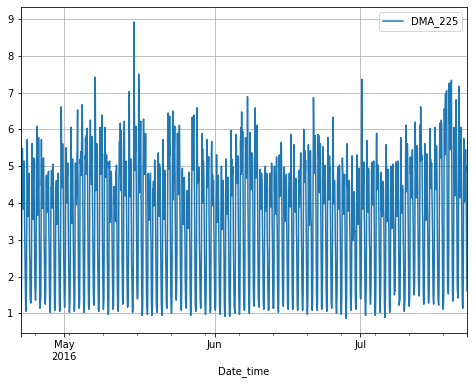

<Figure size 1584x720 with 0 Axes>

In [15]:
# Looking at plots
DMA225_df_indexed = data_DMA225_indexed[['DMA_225']]
DMA225_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [16]:
df1 = data_DMA225_indexed[0:1104]
df2 = data_DMA225_indexed[1104:2209]

In [17]:
df1.shape

(1104, 1)

In [18]:
df2.shape

(1104, 1)

In [19]:
df1_Mean = df1.mean()
df1_Variance = df1.var()
print("The mean of df1: ",df1_Mean)
print("The Std of df1: ",df1_Variance)

The mean of df1:  DMA_225    3.538215
dtype: float64
The Std of df1:  DMA_225    2.755508
dtype: float64


In [20]:
df2_Mean = df2.mean()
df2_Variance = df2.var()
print("The mean of df2: ",df2_Mean)
print("The Std of df2: ",df2_Variance)

The mean of df2:  DMA_225    3.586
dtype: float64
The Std of df2:  DMA_225    2.61362
dtype: float64


In [21]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(data_DMA225_indexed)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.786571
p-value: 0.000058
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Observation :

1.The ADF statistic value of -4. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [22]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(data_DMA225_indexed)
KPSS_Check_Stationary

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.31173911268265597,
 0.1,
 27,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

#Observation :

1.The ADF statistic value of 0.3. The positive value is statistic, and hence we have a stationary dataset.

2.p value - 0.1 > 0.05 ; Data is stationary

# Time series decomposition:

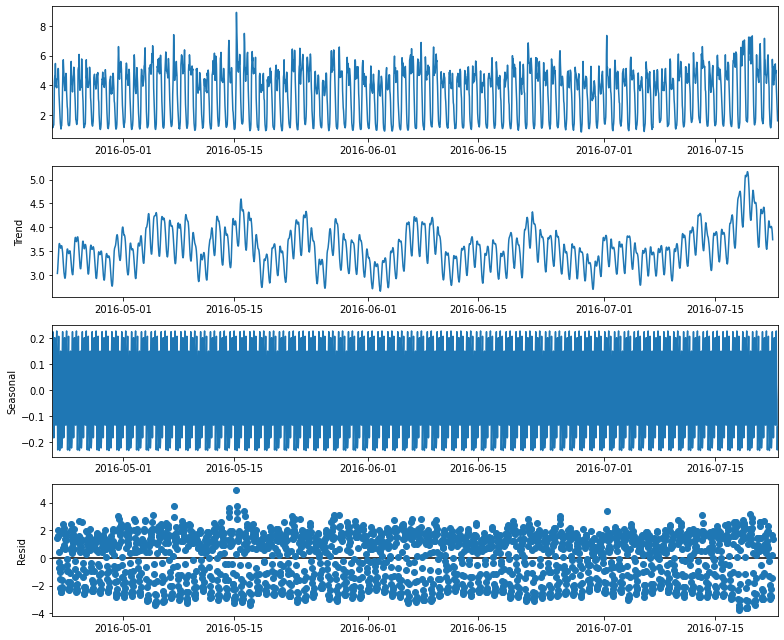

In [23]:
rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(data_DMA225_indexed, period = 30, model='additive')
fig = decomposition.plot()
plt.show()

# Autocorrelation and partial autocorrelation graphs

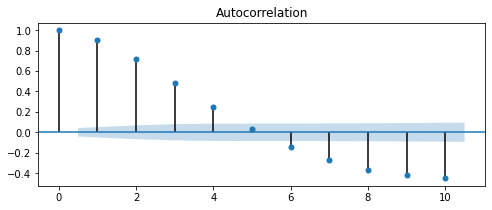

In [24]:
fig,ax = plt.subplots(figsize=(8,3))
plot_acf(data_DMA225_indexed,ax=ax,lags=10)
plt.show()

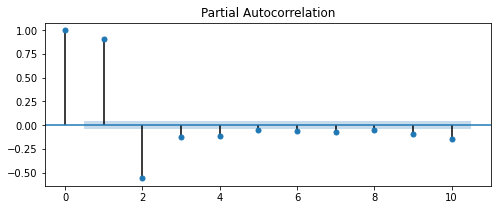

In [25]:
fig,ax = plt.subplots(figsize=(8,3))
plot_pacf(data_DMA225_indexed,ax=ax,lags=10)
plt.show()

In [26]:
autoarima_Model = pm.auto_arima(data_DMA225_indexed,m=3,
                      seasonal=True,start_p =0,start_q =0,max_order =4,error_action='ignore',
                      trace=True,suppress_warnings=True,stepwise=True,random_state =20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[3] intercept   : AIC=7490.768, Time=1.56 sec
 ARIMA(0,0,0)(0,0,0)[3] intercept   : AIC=8448.942, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[3] intercept   : AIC=4698.645, Time=1.40 sec
 ARIMA(0,0,1)(0,0,1)[3] intercept   : AIC=5834.252, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[3]             : AIC=12301.399, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[3] intercept   : AIC=4703.791, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[3] intercept   : AIC=4596.199, Time=2.84 sec
 ARIMA(1,0,0)(2,0,1)[3] intercept   : AIC=4509.926, Time=4.91 sec
 ARIMA(1,0,0)(1,0,1)[3] intercept   : AIC=4652.172, Time=4.07 sec
 ARIMA(1,0,0)(2,0,2)[3] intercept   : AIC=4641.988, Time=6.67 sec
 ARIMA(1,0,0)(1,0,2)[3] intercept   : AIC=4532.607, Time=4.61 sec
 ARIMA(0,0,0)(2,0,1)[3] intercept   : AIC=7018.331, Time=4.17 sec
 ARIMA(2,0,0)(2,0,1)[3] intercept   : AIC=3826.428, Time=6.15 sec
 ARIMA(2,0,0)(1,0,1)[3] intercept   : AIC=3827.964, Time=4.74 sec
 ARIMA(2,0,0)(2,0,0)[3] intercep

In [27]:
autoarima_Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2208
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 3)   Log Likelihood               -1834.818
Date:                           Tue, 09 Feb 2021   AIC                           3687.635
Time:                                   00:41:54   BIC                           3738.934
Sample:                                        0   HQIC                          3706.377
                                          - 2208                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0303      0.012      2.608      0.009       0.008       0.053
ar.L1          1.8236      0.016    116.013      0.000       1.793       1.854
ar.L2         -0.8997      0.014    -64.423      0.000      -0.927      -0.872
ma.L1         -0.5108      0.022    -22.745      0.000      -0.555      -0.467
ma.L2         -0.2796      0.021    -13.035      0.000      -0.322      -0.238
ar.S.L3        0.8877      0.042     21.161      0.000       0.805       0.970
ma.S.L3       -0.9780      0.048    -20.413      0.000      -1.072      -0.884
ma.S.L6        0.1342      0.022      6.059      0.000       0.091       0.178
sigma2         0.3041      0.008     39.309      0.000       0.289       0.319
===================================================================================
Ljung-Box (L1) (Q):                   2.97   Jarque-Bera (JB):               527.99
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.53
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

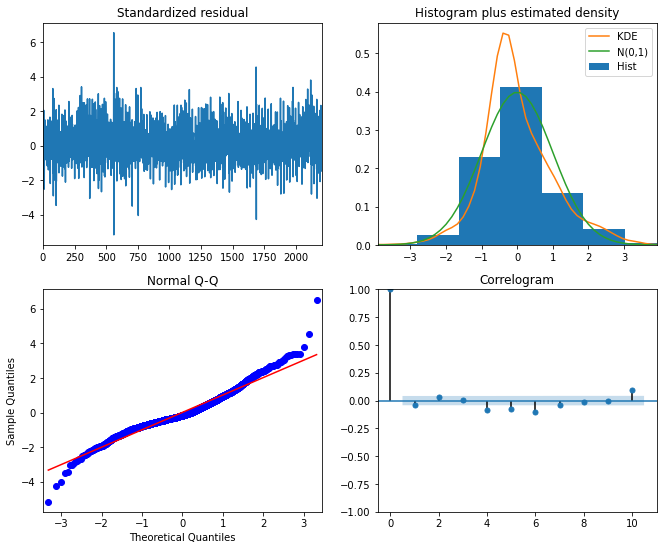

In [28]:
autoarima_Model.plot_diagnostics()
plt.show()

In [29]:
# Train Test Split Index
size_of_trainset = 0.7
split_value = round(len(data_DMA225_indexed)* size_of_trainset)

# Split
train = data_DMA225_indexed.iloc[:split_value]
test = data_DMA225_indexed.iloc[split_value:]

print(data_DMA225_indexed.shape)
print(train.shape,test.shape)


(2208, 1)
(1546, 1) (662, 1)


In [30]:
autoarima_Model.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 2, 3),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [33]:
pf = autoarima_Model.predict(n_periods=len(test),return_conf_int=True)

In [34]:
pf_df=pd.DataFrame(pf[0],index=test.index,columns=["WDP"])

In [35]:
pf_df.shape

(662, 1)

In [41]:
test.shape

(662, 1)

In [42]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

mse = (mean_squared_error(test,pf_df))
rms = sqrt(mean_squared_error(test,pf_df))

print("mse:" ,mse)
print("rms: ",rms)

mse: 2.6272332021687603
rms:  1.6208742092367194
